In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import torch
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as F
import models.model_selector
from torchvision import datasets
from skimage.segmentation import mark_boundaries
from lime import lime_image

C:\Users\Shaw\anaconda3\envs\Pytorch39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_input_transform():   
    transf = transforms.Compose([
        transforms.ToTensor()
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    return transf(img).unsqueeze(0)

def get_pil_transform(): 
    transf = transforms.Compose([
    ])    

    return transf
def get_preprocess_transform():
    transf = transforms.Compose([
        transforms.ToTensor(),
    ])    
    return transf    

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

# To modify the network, make changes to the brackets [] in model_architecture['resnet18']. The model_selector contains all the networks included.

In [3]:
num_classes = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.model_selector.model_architecture['resnet18'](num_classes).to(device)
model.load_state_dict(torch.load('./saved/result_resnet18_cifar100.pt'))
dataset = datasets.CIFAR100(root='../XAI/LIME/datasets/cifar100/cifar-100-python', train=False, download=False)

In [4]:
class_names = dataset.classes
idx2label = {k: class_names[k] for k in range(len(class_names))}
label2idx = {class_names[k]: k for k in range(len(class_names))}

## This requires a lot of memory if you want to test an image by file.

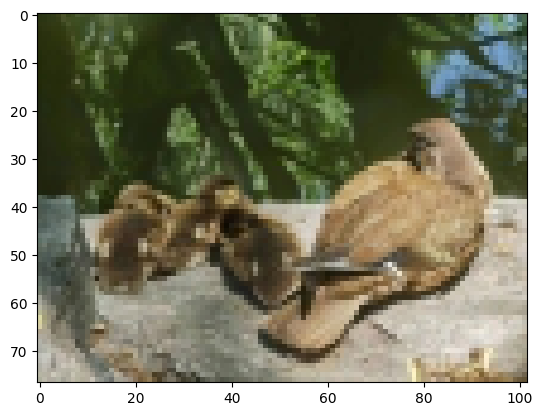

In [105]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('./bird.jpg')
plt.imshow(img)
img_t = get_input_tensors(img)
img_t = img_t.to(device)
model.eval()
logits = model(img_t)

## Test an image from CIFAR100

37


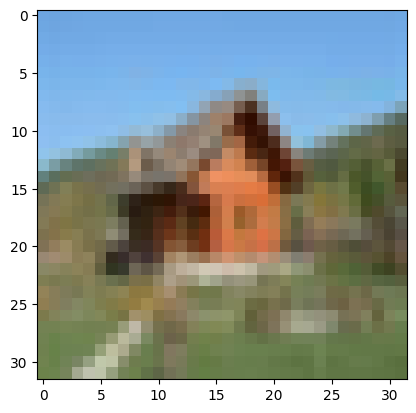

In [131]:
index = 1503
img = dataset[index][0]
img.convert('RGB')
plt.imshow(img)
# plt.savefig('./visualization/ori_standard.jpg')
print(dataset[index][1])
img_t = get_input_tensors(img)
img_t = img_t.to(device)
model.eval()
logits = model(img_t)

In [132]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].cpu().detach().numpy(), probs5[1][0].cpu().detach().numpy()))

((0.9998041, 37, 'house'),
 (1.6884054e-05, 17, 'castle'),
 (5.227289e-06, 81, 'streetcar'),
 (4.198891e-06, 15, 'camel'),
 (3.307451e-06, 31, 'elephant'))

In [133]:
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()
test_pred = batch_predict([img])
test_pred.squeeze().argmax()

37

In [134]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

100%|█████████████████████████████████████| 1000/1000 [00:01<00:00, 701.06it/s]


# top_labels[0] represents the top-ranked label in terms of accuracy, with a total of five labels.

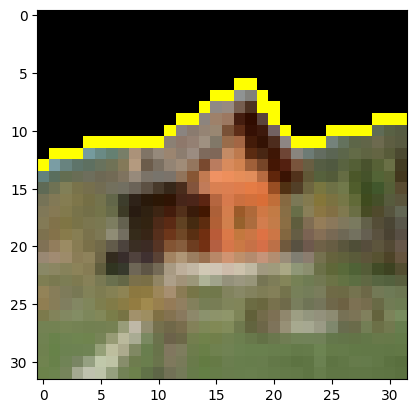

In [141]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255, mask)
plt.imshow(img_boundry1)
# plt.savefig('./visualization/boundry_standard.jpg')

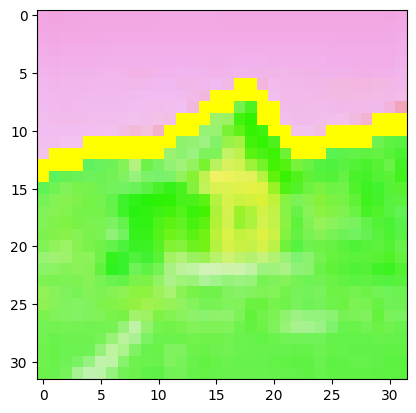

In [137]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
# plt.savefig('./visualization/boundry2_standard.jpg')